In [64]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import clear_output
import time
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

In [65]:
# geodata = pd.read_csv('CommunityClubsTest-clean.csv')
# print(geodata)
# bloodbankcoords = pd.read_csv('HSA bloodbank coordinates1.csv')
# print(bloodbankcoords)
# privhospcoords = pd.read_csv("Plot_of_Hospitals,_Blood_Banks_&_Community_Centers_Private_Hospital (3).csv")
# pubhospcoords = pd.read_csv("Plot_of_Hospitals,_Blood_Banks_&_Community_Centers_Public_Hospital (3).csv")

In [66]:
# # y-coordinates/latitude of CCs, BBs and hospitals
# y_coordCC = geodata['Y']
# y_coordBB = bloodbankcoords['Latitude']
# y_coord_privhosp = privhospcoords['Latitude']
# y_coord_pubhosp = pubhospcoords['Latitude']

# # x-coordinates/longitude of CCs, BBs and hospitals
# x_coordCC = geodata['X']
# x_coordBB = bloodbankcoords['Longitude']
# x_coord_privhosp = privhospcoords['Longitude']
# x_coord_pubhosp = pubhospcoords['Longitude']


# #no. of BBs
# nbrblood = 5

# #no. of CCs
# nbrcomm = 125

# #no. of private hosps
# nbrprivh = 9

# #no. of public hosps
# nbrpubh = 10

# #radius of earth
# R = 6371


# def deg_to_rad(degrees):
#     return degrees*(np.pi/180)

# # distance calculations between CC and BBs
# distancelct=np.empty([nbrblood, nbrcomm])
# for i_index in range(nbrblood):
#     for j_index in range(nbrcomm):
#         d_lon = deg_to_rad(x_coordBB[i_index]-x_coordCC[j_index])
#         d_lat = deg_to_rad(y_coordBB[i_index]-y_coordCC[j_index])
#         a = np.sin(d_lat/2)**2 +np.cos(deg_to_rad(x_coordBB[i_index])) * np.cos(deg_to_rad(x_coordCC[j_index])) * np.sin(d_lon/2)**2
#         c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
#         distancelct[i_index,j_index] = R*c

# # print(distancelct)

# # Distance calculation between BBs and private hospitals
# distanceBB_priv = np.empty((nbrblood, nbrprivh))

# for i_index in range(nbrblood):  # loop over blood banks
#     for h_index in range(nbrprivh):  # loop over private hospitals
#         d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_privhosp[h_index])
#         d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_privhosp[h_index])
#         a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_privhosp[h_index])) * np.sin(d_lon / 2) ** 2
#         c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         distanceBB_priv[i_index, h_index] = R * c


# distanceBB_pub = np.empty((nbrblood, nbrpubh))

# for i_index in range(nbrblood):  # loop over blood banks
#     for h_index in range(nbrpubh):  # loop over public hospitals
#         d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_pubhosp[h_index])
#         d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_pubhosp[h_index])
#         a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_pubhosp[h_index])) * np.sin(d_lon / 2) ** 2
#         c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         distanceBB_pub[i_index, h_index] = R * c


In [67]:
# --- Replace the data loading and initialization section with the following ---
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Problem size
nbrblood = 3
nbrcoll = 15
nbrprivh = 3
nbrpubh = 4

# Generate random coordinates for community centers, blood banks, and hospitals
# Assume coordinates are in a 100x100 grid
x_coordCC = np.random.uniform(0, 100, nbrcoll)
y_coordCC = np.random.uniform(0, 100, nbrcoll)
x_coordBB = np.random.uniform(0, 100, nbrblood)
y_coordBB = np.random.uniform(0, 100, nbrblood)
x_coord_privhosp = np.random.uniform(0, 100, nbrprivh)
y_coord_privhosp = np.random.uniform(0, 100, nbrprivh)
x_coord_pubhosp = np.random.uniform(0, 100, nbrpubh)
y_coord_pubhosp = np.random.uniform(0, 100, nbrpubh)

# Radius of earth (not used for random Euclidean distances, but kept for compatibility)
R = 6371

def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# Use Euclidean distance for random data
distancelct = np.empty([nbrblood, nbrcoll])
for i_index in range(nbrblood):
    for j_index in range(nbrcoll):
        distancelct[i_index, j_index] = np.linalg.norm(
            [x_coordBB[i_index] - x_coordCC[j_index], y_coordBB[i_index] - y_coordCC[j_index]]
        )

distanceBB_priv = np.empty((nbrblood, nbrprivh))
for i_index in range(nbrblood):
    for h_index in range(nbrprivh):
        distanceBB_priv[i_index, h_index] = np.linalg.norm(
            [x_coordBB[i_index] - x_coord_privhosp[h_index], y_coordBB[i_index] - y_coord_privhosp[h_index]]
        )

distanceBB_pub = np.empty((nbrblood, nbrpubh))
for i_index in range(nbrblood):
    for h_index in range(nbrpubh):
        distanceBB_pub[i_index, h_index] = np.linalg.norm(
            [x_coordBB[i_index] - x_coord_pubhosp[h_index], y_coordBB[i_index] - y_coord_pubhosp[h_index]]
        )

# Generate random blood collection amounts and capacities
q_c = np.random.randint(1, 10, nbrcoll)  # Amount of blood collected at each CC
g_b = np.random.randint(50, 100, nbrblood)  # Min blood required at each bank
q_b = np.random.randint(100, 200, nbrblood)  # Max capacity at each bank

# For hospital demand, generate random values for demonstration
hospital_demand = np.random.randint(1, 10, nbrprivh + nbrpubh)

# Prepare coordinates for plotting and TSP
comm_coords = list(zip(x_coordCC, y_coordCC))
bank_coords = list(zip(x_coordBB, y_coordBB))
privhosp_coords = list(zip(x_coord_privhosp, y_coord_privhosp))
pubhosp_coords = list(zip(x_coord_pubhosp, y_coord_pubhosp))

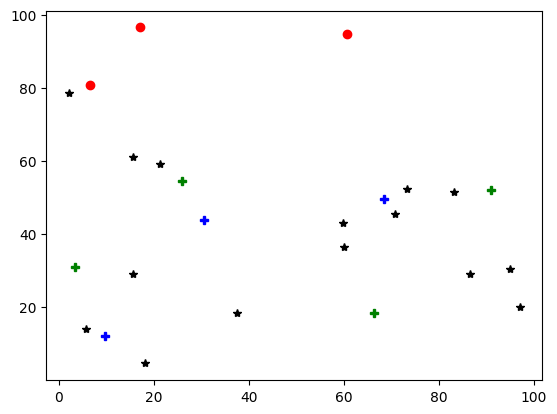

In [68]:
# 'coordlct_x' and 'coordlct_y' represent the coordinates of the facilities.
plt.plot(x_coordCC, y_coordCC, '*', color='black');
plt.plot(x_coordBB, y_coordBB, 'o', color='red');
plt.plot(x_coord_privhosp, y_coord_privhosp, 'P', color='blue')
plt.plot(x_coord_pubhosp, y_coord_pubhosp, 'P', color='green')

In [ ]:
# Initialize empty solutions to populate from each iteration of epsilon-constraint method 
optimal_costs = []
optimal_distances = []
detailed_solutions = []


 #Create Model
model = gp.Model("P_Median_Epsilon_Constraint_Style")

I = list(range(nbrblood)) #Open Facilities  
J = list(range(nbrcoll)) #Facilities to be served
H_priv = list(range(nbrprivh))                          
H_pub = list(range(nbrprivh, nbrprivh + nbrpubh))        
H = H_priv + H_pub                                       

 # Define variables:
x = model.addVars(I, J, vtype=GRB.BINARY, name="assign")  # If demand from location i is served by open facility j then x_ij=1 otherwise x_ij=0
y = model.addVars(I, vtype=GRB.BINARY, name="open") # Facility i to open. y_i=0 if closed and y_i=1 if open
z = model.addVars(I, H, vtype=GRB.BINARY, name="deliver") # Deliver from blood banks to hospitals

 # Define objective functions

 # Minimize total distance from demands to the nearest open facilities
 # Each demand location j must be assigned to exactly one facility i
model.addConstrs((gp.quicksum(x[i, j] for i in I) == 1 for j in J), name="assign_once")
 # The demand from location i can only be assigned to an open facility j
model.addConstrs((x[i, j] <= y[i] for i in I for j in J), name="only_open")
model.addConstr(gp.quicksum(y[i] for i in I) == nbrblood, name="open_facilities")

# model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) >= np.sum(g_b), name="lower_bound_sum")

# model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) <= 328*1.1*10, name="upper_bound_sum")

model.addConstrs((gp.quicksum(x[i, j] for j in J) <= q_b[i] * y[i] for i in I), name="capacity_constraints")  # Capacity constraints for each bank


f_bc = 0.094*2.61
model.addConstr(gp.quicksum(f_bc*distancelct[i][j] * x[i, j] for i in I for j in J) <= 1000, name="budget_constraint")

# # Add constraints for blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for i in I) == 1 for h in H), name="deliver_once")  # Each hospital must receive blood from exactly one bank
model.addConstrs((z[i, h] <= y[i] for i in I for h in H), name="only_open_delivery")  # Blood can only be delivered from open banks 
model.addConstrs((gp.quicksum(z[i, h] for i in I) <= q_c[h] for h in H), name="delivery_capacity")  # Capacity constraints for each hospital
# # Add constraints for maximum blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for h in H) <= q_c[i] for i in I), name="max_blood_delivery")  # Maximum blood delivery from each bank

model.addConstrs((gp.quicksum(x[i, j] for j in J) >= 1 * y[i] for i in I), name="min_assignments")

# For each blood bank k, and each pair of assigned CCs (i, j), define:
# u[k, i, j] = 1 if blood bank k travels from CC i to CC j, 0 otherwise

u = model.addVars(nbrblood, nbrcoll, nbrcoll, vtype=GRB.BINARY, name="route")
for k in range(nbrblood):
    for i in range(nbrcoll):
        model.addConstr(gp.quicksum(u[k, i, j] for j in range(nbrcoll) if j != i) == x[k, i])
        model.addConstr(gp.quicksum(u[k, j, i] for j in range(nbrcoll) if j != i) == x[k, i])
# Add continuous variables for MTZ
mtz = model.addVars(nbrblood, nbrcoll, vtype=GRB.CONTINUOUS, lb=0, ub=nbrcoll, name="mtz")

for k in range(nbrblood):
    for i in range(1, nbrcoll):
        for j in range(1, nbrcoll):
            if i != j:
                model.addConstr(mtz[k, i] - mtz[k, j] + nbrcoll * u[k, i, j] <= nbrcoll - 1)

model.setObjective(
    gp.quicksum(x[i, j] * distancelct[i][j] for i in I for j in J) +
    gp.quicksum(z[i, h] * distanceBB_priv[i][h] for i in I for h in H_priv) +
    gp.quicksum(z[i, h] * distanceBB_pub[i][h - nbrprivh] for i in I for h in H_pub)+
    gp.quicksum(u[k, i, j] * np.linalg.norm(np.array(comm_coords[i]) - np.array(comm_coords[j]))
               for k in range(nbrblood) for i in range(nbrcoll) for j in range(nbrcoll) if i != j),
    GRB.MINIMIZE
)

# # # Optimize the model
model.optimize()

# Check if a solution was found
if model.status == gp.GRB.OPTIMAL:
    print(f"Optimal objective value: {model.objVal}")

    # Print values of decision variables
    for var in model.getVars():
        if var.X > 1e-6:  # print only non-zero values
            print(f"{var.VarName} = {var.X}")
else:
    print("No optimal solution found.")

# After model.optimize() and extracting x_vals
assignments = {idx: [] for idx in I}
for idx in I:
    for j in J:
        if x[idx, j].X > 0.5:
            assignments[idx].append(j)




Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 742 rows, 789 columns and 3372 nonzeros
Model fingerprint: 0x40be4594
Variable types: 45 continuous, 744 integer (744 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+03]
Presolve removed 103 rows and 87 columns
Presolve time: 0.02s
Presolved: 639 rows, 702 columns, 3076 nonzeros
Variable types: 42 continuous, 660 integer (660 binary)

Root relaxation: objective 1.410797e+03, 75 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1410.79683    0   40          - 141

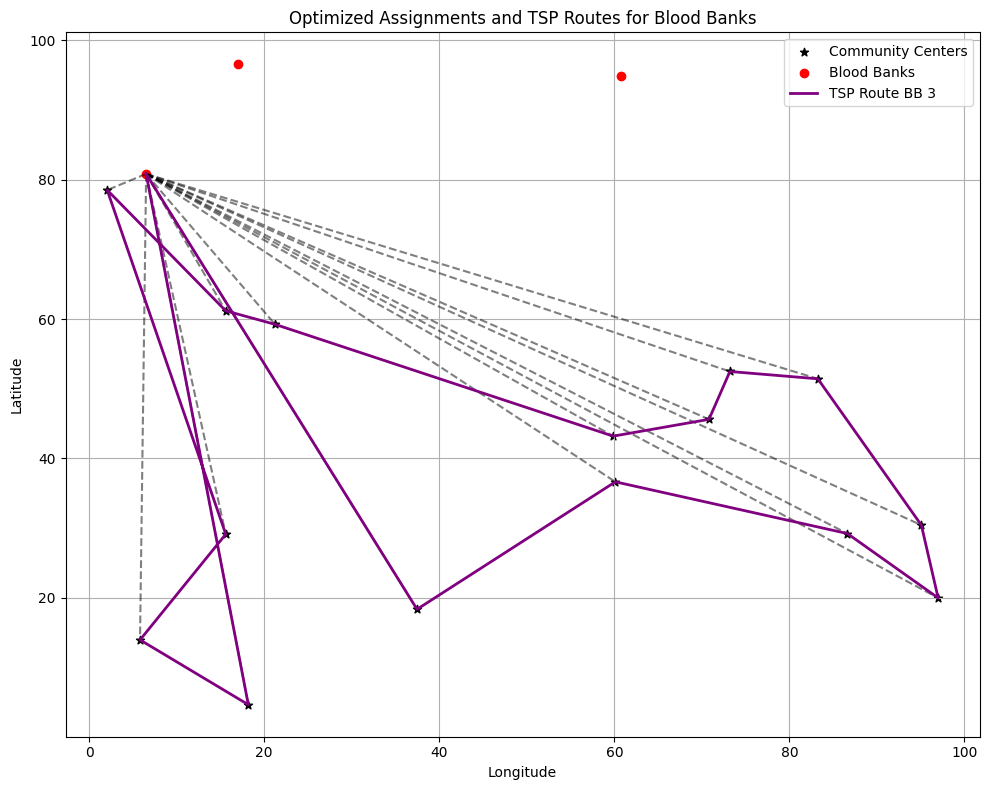

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 8))

# Plot community centers and blood banks
plt.scatter([c[0] for c in comm_coords], [c[1] for c in comm_coords], c='black', marker='*', label='Community Centers')
plt.scatter([b[0] for b in bank_coords], [b[1] for b in bank_coords], c='red', marker='o', label='Blood Banks')

# Draw assignment lines (gray dashed)
for k in I:
    for j in assignments[k]:
        bx, by = bank_coords[k]
        cx, cy = comm_coords[j]
        plt.plot([bx, cx], [by, cy], 'k--', alpha=0.5)

# Optionally, plot TSP routes for each blood bank
def extract_tsp_route(u, k, nbrcoll):
    # Simple greedy extraction (not guaranteed to be optimal order, but shows the route)
    route = []
    visited = set()
    # Find start node (assigned to k)
    for i in range(nbrcoll):
        if sum(u[k, i, j].X for j in range(nbrcoll) if j != i) > 0.5:
            current = i
            break
    route.append(current)
    while len(route) < len(assignments[k]):
        for j in range(nbrcoll):
            if j != current and u[k, current, j].X > 0.5 and j not in visited:
                route.append(j)
                visited.add(current)
                current = j
                break
        else:
            break
    return route

colors = ['orange', 'green', 'purple', 'brown', 'magenta']
for k in I:
    if assignments[k]:
        route = extract_tsp_route(u, k, nbrcoll)
        if route:
            path = [bank_coords[k]] + [comm_coords[j] for j in route] + [bank_coords[k]]
            path_x, path_y = zip(*path)
            plt.plot(path_x, path_y, color=colors[k % len(colors)], linewidth=2, label=f'TSP Route BB {k+1}')

plt.title("Optimized Assignments and TSP Routes for Blood Banks")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()